<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Resnet50_KFoldCrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
from sklearn.metrics import confusion_matrix
import ast

# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
 99% 1.61G/1.62G [00:13<00:00, 166MB/s]
100% 1.62G/1.62G [00:13<00:00, 133MB/s]


# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

# Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Distribution of disease instances

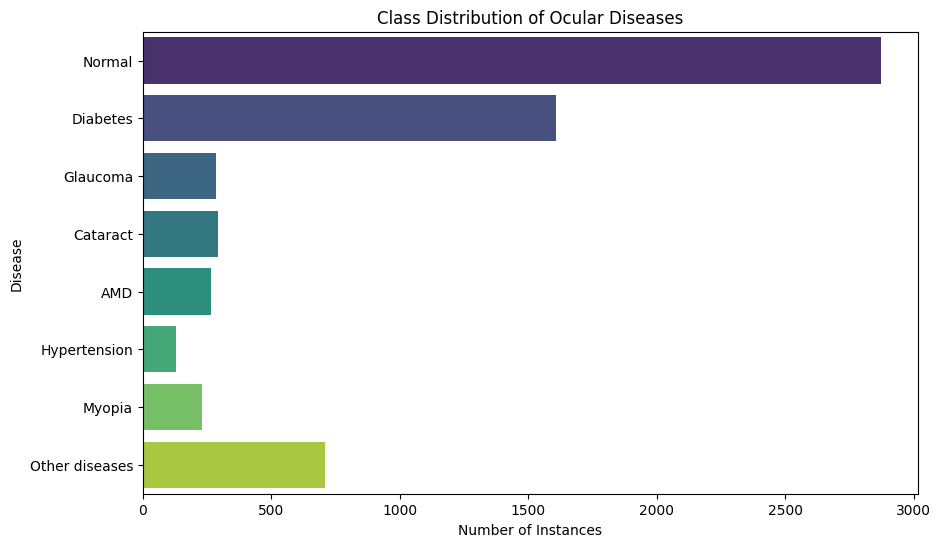

In [10]:
# Define the class labels as provided by the user
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_data['class_name'] = df_data['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_data['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the class distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.values, y=class_counts.index, hue=class_counts.index, palette="viridis", legend=False)
plt.title('Class Distribution of Ocular Diseases')
plt.xlabel('Number of Instances')
plt.ylabel('Disease')
plt.show()


# Splitting the Data

In [11]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and test sets first
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)


# Data Distribution
- Class imbalance, we have minority classes M, H, G, C, A.

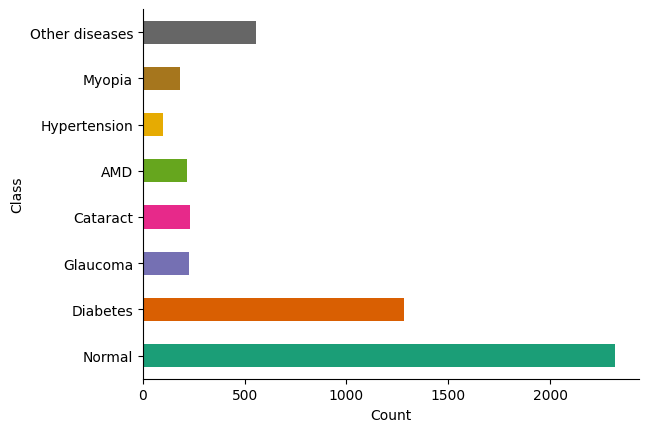

In [12]:
# @title Distribution of Training Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
train_df['class_name'] = train_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = train_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

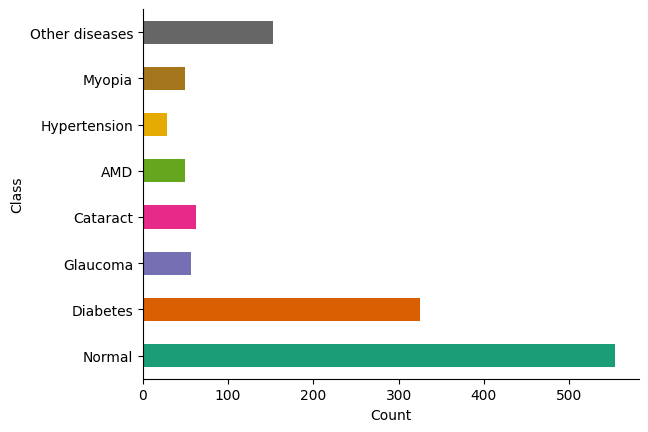

In [13]:
# @title Distribution of Test Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = test_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

#Data Prep for Stratified K-Fold cross-validation

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)
# Initialize performance record
fold_no = 1
scores_per_fold = []

##Pretrained Resnet 50 Model

In [16]:
def build_model(num_classes=8):
    # Load the ResNet50 model, pre-trained on ImageNet data
    pretrained_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg',
        weights='imagenet'
    )

    # Freeze the layers of the pretrained model
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Create the model
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Use num_classes for generalizability

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Data Preparation

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input



def get_data_generators(train_data, val_data, images_dir, batch_size=32):
    # Create ImageDataGenerators for augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input # Apply ResNet50 preprocessing
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Assuming 'Left-Fundus' column has image filenames and 'target' column has labels
    # Adjust the 'x_col' and 'y_col' parameters as per your dataframe structure
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=images_dir,
        x_col='filename',
        y_col='target',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'  # or 'raw' if your labels are already one-hot encoded
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=images_dir,
        x_col='filename',
        y_col='target',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'  # or 'raw'
    )

    return train_generator, validation_generator


In [24]:
all_train_loss_histories = []
all_val_loss_histories = []
all_train_acc_histories = []
all_val_acc_histories = []


for train_index, val_index in skf.split(np.zeros(len(train_df)), train_df['target']):
    # Generate batches of train and validation data using the indices
    training_data = train_df.iloc[train_index]
    validation_data = train_df.iloc[val_index]

    images_dir = 'ODIR-5K/ODIR-5K/Training Images/'
    # Create the data generators
    train_generator, validation_generator = get_data_generators(training_data, validation_data, images_dir, batch_size=32)

    # Build the model architecture
    model = build_model()  # Implement this function based on your model architecture

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples// 32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples// 32
    )

   # Collect histories
    all_train_loss_histories.append(history.history['loss'])
    all_val_loss_histories.append(history.history['val_loss'])
    all_train_acc_histories.append(history.history['accuracy'])
    all_val_acc_histories.append(history.history['val_accuracy'])


    # Save scores for this fold
    scores = model.evaluate(validation_generator, steps=validation_generator.samples // 32)
    scores_per_fold.append(scores)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    # Increase fold number
    fold_no = fold_no + 1

    # Clear model from memory after each fold if you're not saving models
    del model
    tf.keras.backend.clear_session()

Found 4090 validated image filenames belonging to 8 classes.
Found 1023 validated image filenames belonging to 8 classes.
Epoch 1/10
127/127 [==============================] - 96s 730ms/step - loss: 1.3571 - accuracy: 0.5002 - val_loss: 1.1962 - val_accuracy: 0.5343
Epoch 2/10
127/127 [==============================] - 92s 727ms/step - loss: 1.1501 - accuracy: 0.5584 - val_loss: 1.1688 - val_accuracy: 0.5353
Epoch 3/10
127/127 [==============================] - 88s 696ms/step - loss: 1.0946 - accuracy: 0.5821 - val_loss: 1.1862 - val_accuracy: 0.5534
Epoch 4/10
127/127 [==============================] - 89s 697ms/step - loss: 1.0558 - accuracy: 0.5853 - val_loss: 1.1495 - val_accuracy: 0.5565
Epoch 5/10
127/127 [==============================] - 90s 706ms/step - loss: 0.9957 - accuracy: 0.6171 - val_loss: 1.1195 - val_accuracy: 0.5796
Epoch 6/10
127/127 [==============================] - 89s 701ms/step - loss: 0.9719 - accuracy: 0.6193 - val_loss: 1.2235 - val_accuracy: 0.5383
Epoch 7/

# Evaluating Cross Validation Performance
- Calulating Average Loss and Accuracy
- Displaying Loss abd Accuracy Across Folds


## Plotting KFold Performance per fold

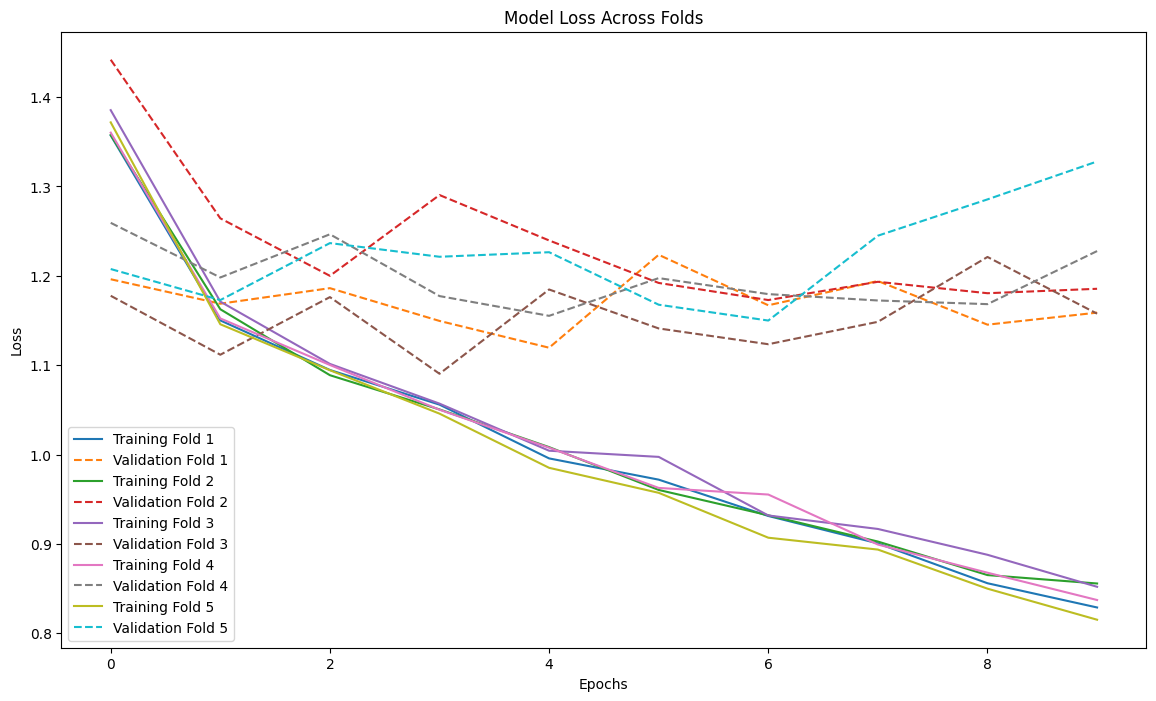

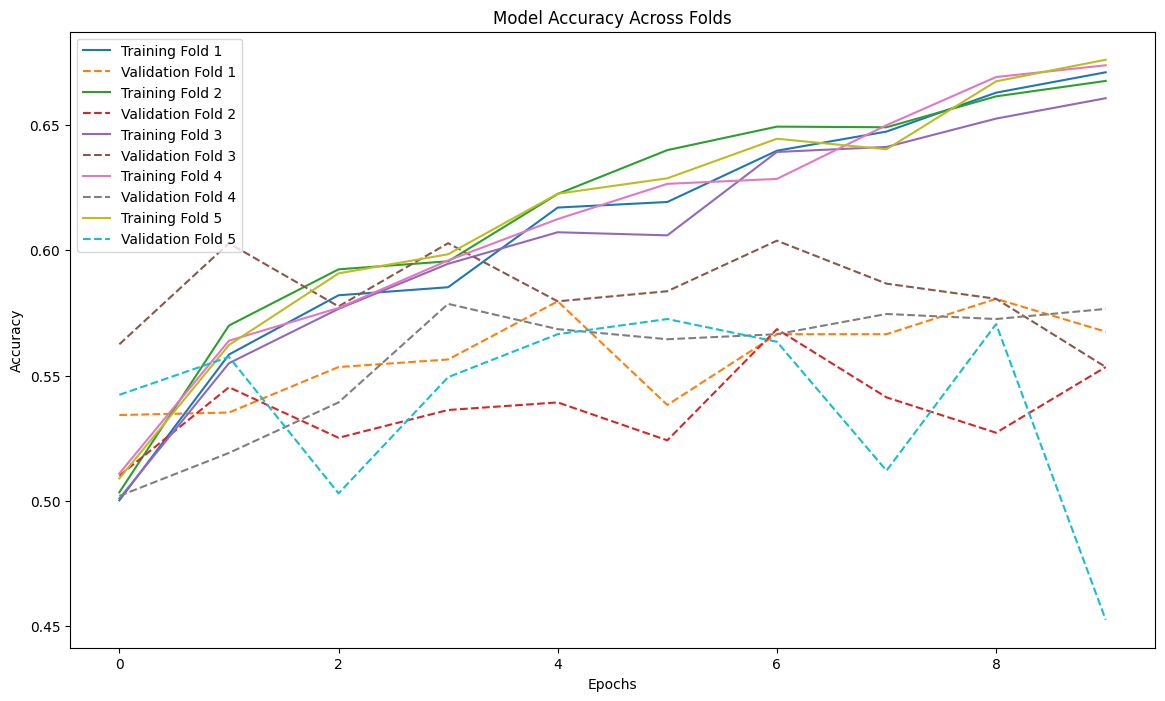

In [26]:
# Function to plot the loss (or accuracy) for each fold
def plot_kfold_metrics(train_histories, val_histories, metric='loss'):
    plt.figure(figsize=(14, 8))

    for i in range(len(train_histories)):
        plt.plot(train_histories[i], label=f'Training Fold {i+1}')
        plt.plot(val_histories[i], label=f'Validation Fold {i+1}', linestyle='--')

    plt.title(f'Model {metric.capitalize()} Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plot loss
plot_kfold_metrics(all_train_loss_histories, all_val_loss_histories, metric='loss')
#Plot accuracy
plot_kfold_metrics(all_train_acc_histories, all_val_acc_histories, metric='accuracy')

In [27]:
# Assuming you've collected 'losses' and 'accuracies' for each fold
# Calculate average and standard deviation for each metric
avg_train_loss = np.mean(all_train_loss_histories, axis=0)
std_train_loss = np.std(all_train_loss_histories, axis=0)
avg_val_loss = np.mean(all_val_loss_histories, axis=0)
std_val_loss = np.std(all_val_loss_histories, axis=0)
avg_train_acc = np.mean(all_train_acc_histories, axis=0)
std_train_acc = np.std(all_train_acc_histories, axis=0)
avg_val_acc = np.mean(all_val_acc_histories, axis=0)
std_val_acc = np.std(all_val_acc_histories, axis=0)

# You might also want to look at the final epoch's performance or the best epoch's performance
# For simplicity, let's consider the performance at the final epoch
final_epoch_val_acc = [hist[-1] for hist in all_val_acc_histories]
best_val_acc_index = np.argmax(final_epoch_val_acc)  # Index of the best performing fold

print(f"Average Training Loss: {avg_train_loss[-1]} ± {std_train_loss[-1]}")
print(f"Average Validation Loss: {avg_val_loss[-1]} ± {std_val_loss[-1]}")
print(f"Average Training Accuracy: {avg_train_acc[-1]} ± {std_train_acc[-1]}")
print(f"Average Validation Accuracy: {avg_val_acc[-1]} ± {std_val_acc[-1]}")

Average Training Loss: 0.8377476096153259 ± 0.014936770168046804
Average Validation Loss: 1.2115347146987916 ± 0.0635435793625213
Average Training Accuracy: 0.6698201060295105 ± 0.005379508188552041
Average Validation Accuracy: 0.5407257974147797 ± 0.04492666997630232


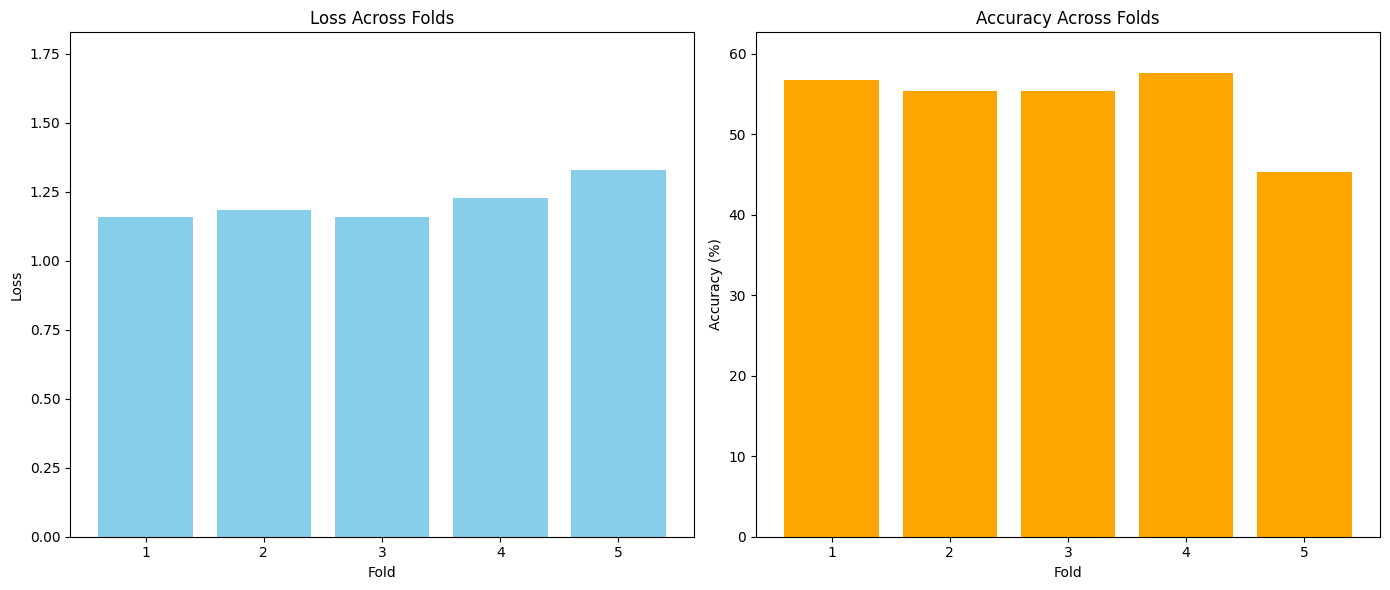

In [28]:
# Extract the final epoch's validation loss and accuracy for each fold
losses = [hist[-1] for hist in all_val_loss_histories]
accuracies = [hist[-1] for hist in all_val_acc_histories]

# Convert accuracies to percentages
accuracies = [acc * 100 for acc in accuracies]

plt.figure(figsize=(14, 6))

# Loss
plt.subplot(1, 2, 1)
plt.bar(range(1, len(losses) + 1), losses, color='skyblue')
plt.title('Loss Across Folds')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.ylim(0, max(losses) + 0.5)

# Accuracy
plt.subplot(1, 2, 2)
plt.bar(range(1, len(accuracies) + 1), accuracies, color='orange')
plt.title('Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.ylim(0, max(accuracies) + 5)

plt.tight_layout()
plt.show()

# Best Model Configuration

In [ ]:
# Assuming you have a function to rebuild the model with specified parameters
best_model_config = {/* parameters of the best model identified during cross-validation */}

# Now, you would retrain your model on the entire dataset using this configuration
final_model = build_model(best_model_config)

# Visualising the training and validation datasets




Training dataset


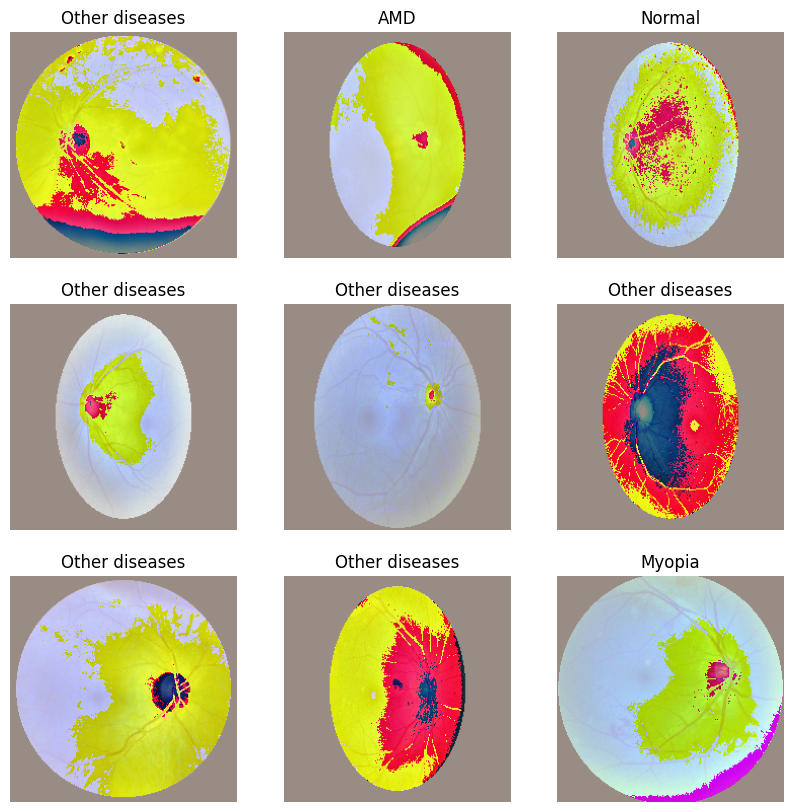

In [ ]:
print("Training dataset")
# Define class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, nrows=3, ncols=3):
    figure, axs = plt.subplots(nrows, ncols, figsize=(10,10))
    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            if index < len(images):  # Check if the index is within the range of images in the batch
                axs[i, j].imshow(images[index].astype('uint8'))
                axs[i, j].set_title(class_labels[np.argmax(labels[index])])
            axs[i, j].axis('off')
# Iterate over the first batch of images and labels from train_set and plot a 9 by 9 grid
batch_size = 32  # Assuming your batch size is 32
for _ in range(1):  # Just take the first batch
    images, labels = next(train_set)
    show_batch(images, labels, nrows=3, ncols=3)
    break  # Break the loop after plotting the first batch

plt.show()

Validation dataset


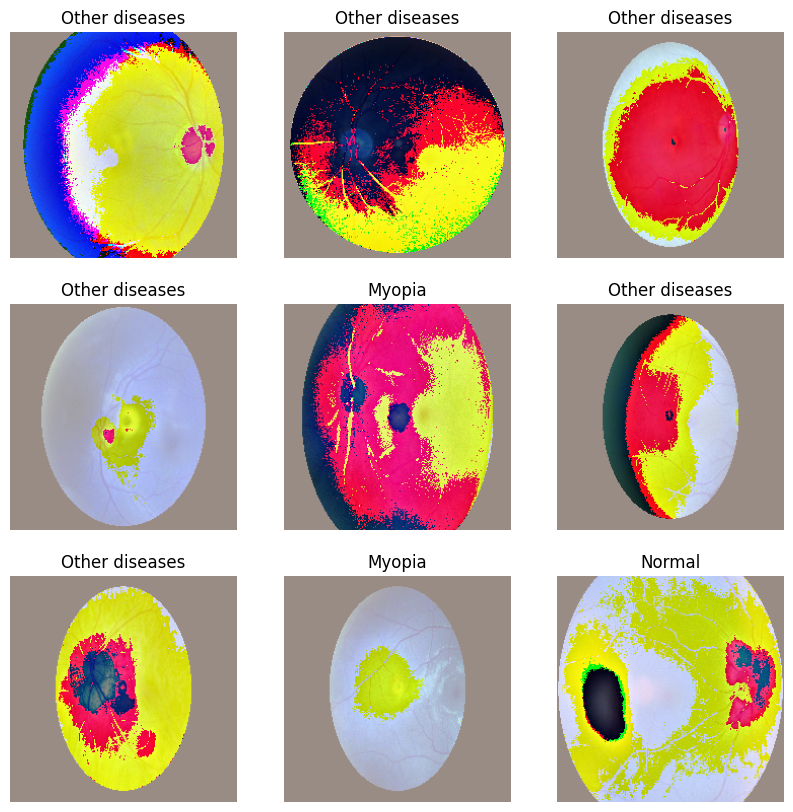

In [ ]:
print("Validation dataset")
# Define class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, nrows=3, ncols=3):
    figure, axs = plt.subplots(nrows, ncols, figsize=(10,10))
    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            if index < len(images):  # Check if the index is within the range of images in the batch
                axs[i, j].imshow(images[index].astype('uint8'))
                axs[i, j].set_title(class_labels[np.argmax(labels[index])])
            axs[i, j].axis('off')
# Iterate over the first batch of images and labels from train_set and plot a 9 by 9 grid
batch_size = 32  # Assuming your batch size is 32
for _ in range(1):  # Just take the first batch
    images, labels = next(val_set)
    show_batch(images, labels, nrows=3, ncols=3)
    break  # Break the loop after plotting the first batch

plt.show()

In [ ]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_set:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Calculate class weights
class_weights = get_class_weights(train_labels)
print("Class weights:", class_weights)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

# Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

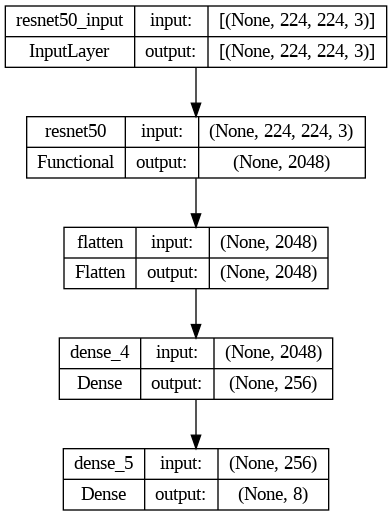

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
    train_set,
    validation_data=val_set,
    steps_per_epoch = train_set.samples//train_set.batch_size,
    validation_steps = val_set.samples//val_set.batch_size,
    epochs=epochs,
    callbacks=callbacks
    )

#Evaluating Model

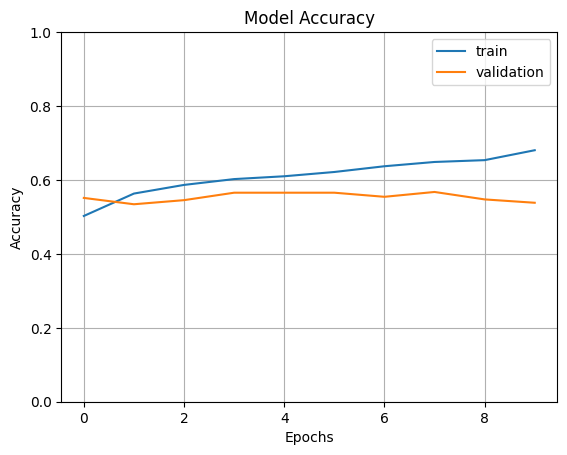

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

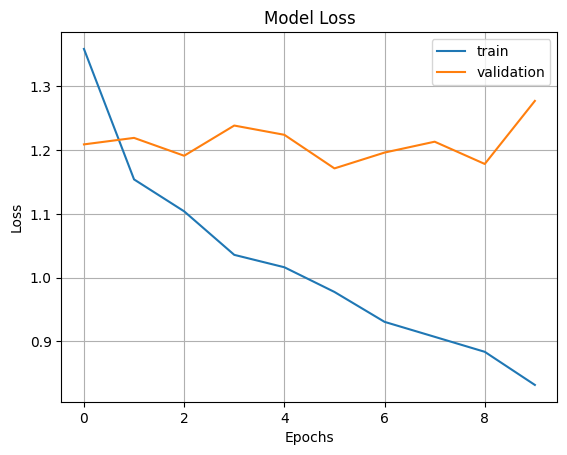

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions


40/40 [==============================] - 24s 602ms/step - loss: 1.1805 - accuracy: 0.5395
Evaluation results: [1.1804630756378174, 0.5394839644432068]


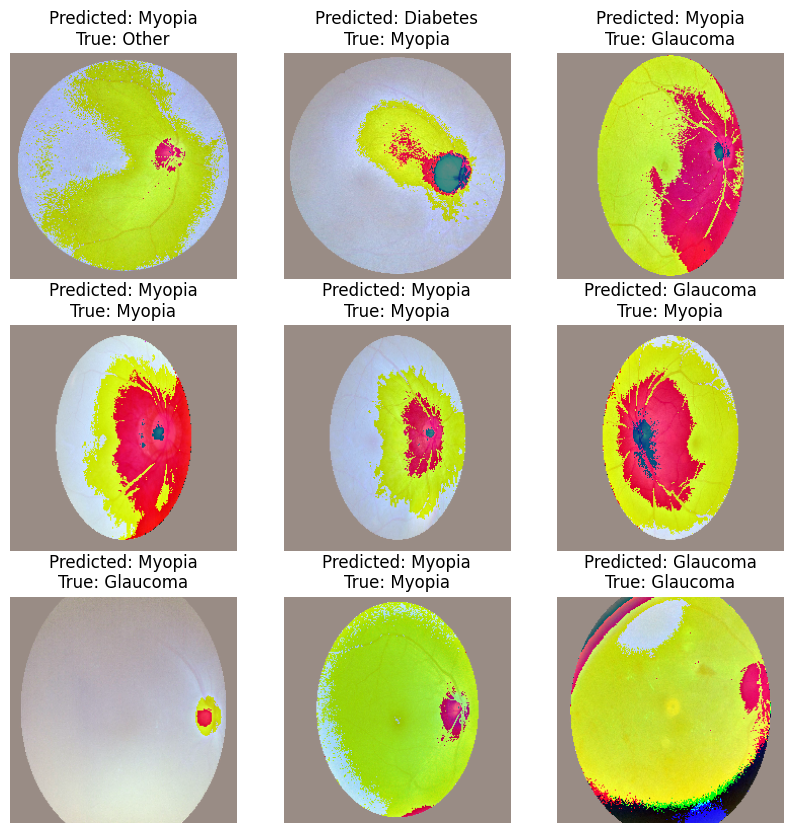

In [ ]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_set.samples
test_batch_size = test_set.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)


# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_set, steps=steps)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_set, steps=steps)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Get the first batch of images and labels
for images, labels in test_set:
    display_images.extend(images[:num_images_to_display])
    display_labels.extend(labels[:num_images_to_display])
    break

# Get the predicted classes for the displayed images
predicted_classes = np.argmax(predictions[:num_images_to_display], axis=1)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(display_images[i].astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

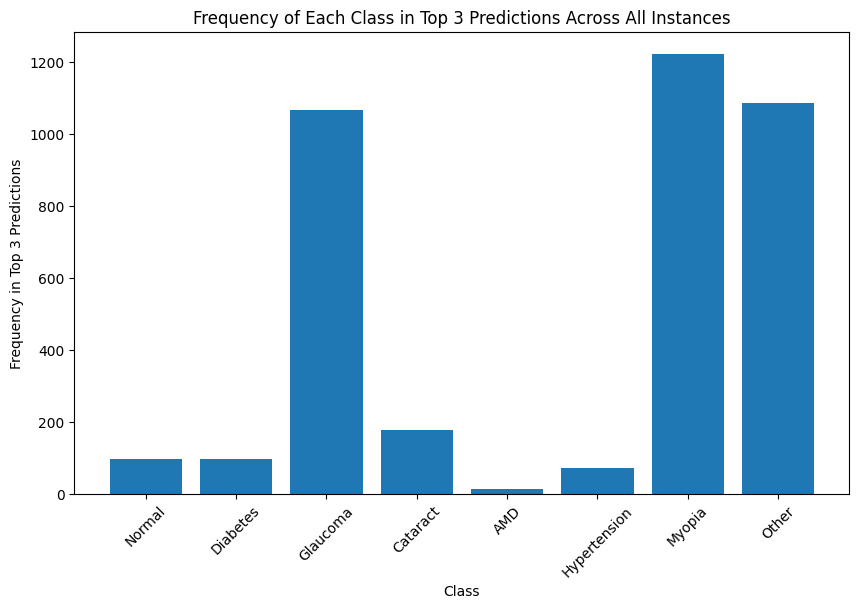

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']
true_classes = test_set.classes
# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

ValueError: Found input variables with inconsistent numbers of samples: [1279, 9]

Balanced Accuracy Score

In [ ]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [ ]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='autumn', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Explainable AI
- SHAP, GradCAM, LIME

# GradCAM

In [ ]:
! pip install opencv-python

In [ ]:
# Define Grad-CAM function for Sequential model
def grad_cam_sequential(model, img_array, last_conv_layer_name, pred_index=None):
    # Find the index of the predicted class
    if pred_index is None:
        pred_index = np.argmax(model.predict(img_array))

    # Get the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Compute gradients of predicted class with respect to last conv layer
    with tf.GradientTape() as tape:
        conv_output = last_conv_layer.output
        tape.watch(conv_output)
        preds = model(img_array)
        loss = preds[:, pred_index]

    grads = tape.gradient(loss, conv_output)

    # Pool gradients across channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get activations of last conv layer
    last_conv_layer_output = conv_output[0]

    # Compute weighted sum of activations and gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap.numpy()

# Choose an image from the test set
img_path = 'ODIR-5K/ODIR-5K/Testing Images/1257_left.jpg'  # Path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Compute Grad-CAM heatmap
last_conv_layer_name = 'conv5_block3_out'  # Name of the last convolutional layer
heatmap = grad_cam_sequential(model, img_array, last_conv_layer_name)

# Resize heatmap to match image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Superimpose heatmap on the original image
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img.astype('uint8'), 0.6, heatmap, 0.4, 0)

# Display the resulting image
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications.resnet50 import  preprocess_input
import shap

In [ ]:
def f(x):
  tmp = x.copy()
  preprocess_input(tmp)
  return model(tmp)

In [ ]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", (224,224,3))

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

In [ ]:
import tensorflow as tf

# Function to load, preprocess images, and prepare labels for SHAP
def parse_image_and_label_for_shap(image_path, label_string):
    # Load the image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [224, 224])
    # Convert image to float32
    image = tf.cast(image, tf.float32)

    # Optionally, preprocess the image for the model as required
    # For SHAP, we might need the raw image or the exact preprocessing used in model training
    # If the original model uses resnet50.preprocess_input, then include it
    #image_preprocessed = tf.keras.applications.resnet50.preprocess_input(image)

    # Process the label string into a tensor
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)

    # Return both preprocessed and raw image if necessary for SHAP
    return  image, label


In [ ]:
def load_and_prepare_dataset(csv_path, images_dir, shuffle=True, batch_size=32):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label_for_shap)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
raw_train_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=64)

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 2/64 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 4/64 [00:16<02:52,  2.87s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 7/64 [00:30<03:46,  3.98s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▎        | 8/64 [00:35<04:17,  4.60s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 9/64 [00:41<04:33,  4.97s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 11/64 [00:51<04:11,  4.74s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 12/64 [00:56<04:22,  5.05s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 13/64 [01:03<04:33,  5.36s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 14/64 [01:08<04:34,  5.49s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 15/64 [01:14<04:34,  5.60s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 17/64 [01:25<04:12,  5.37s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 18/64 [01:30<04:13,  5.51s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 19/64 [01:36<04:11,  5.58s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 22/64 [01:50<03:20,  4.77s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 26/64 [02:09<03:00,  4.76s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 28/64 [02:19<02:50,  4.74s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 29/64 [02:24<02:57,  5.06s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 30/64 [02:30<02:59,  5.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 31/64 [02:36<02:59,  5.43s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 32/64 [02:42<02:57,  5.55s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 34/64 [02:52<02:33,  5.11s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 36/64 [03:01<02:17,  4.92s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 38/64 [03:11<02:05,  4.83s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 39/64 [03:17<02:07,  5.10s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 42/64 [03:30<01:40,  4.56s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 43/64 [03:36<01:43,  4.93s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 44/64 [03:42<01:43,  5.18s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 45/64 [03:48<01:41,  5.37s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 49/64 [04:05<01:07,  4.48s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 51/64 [04:15<00:59,  4.57s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 52/64 [04:21<00:59,  4.93s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 56/64 [04:38<00:34,  4.30s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 57/64 [04:44<00:33,  4.75s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 59/64 [04:54<00:23,  4.69s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 60/64 [04:59<00:19,  5.00s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 61/64 [05:05<00:15,  5.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 62/64 [05:11<00:10,  5.41s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 63/64 [05:17<00:05,  5.53s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 65it [05:26,  5.18s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/shap/plots/_image.py:165: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = axes[row, i + 1].imshow(sv, cmap=cmap, vmin=-max_val, vmax=max_val)


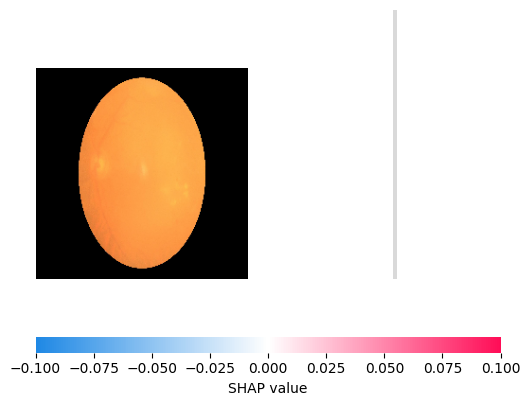

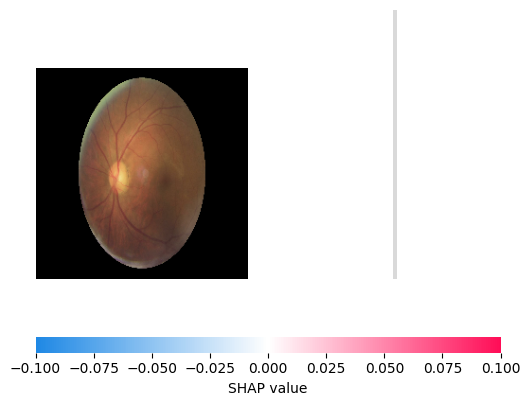

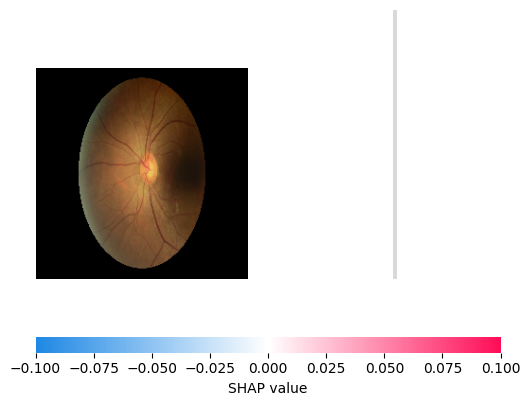

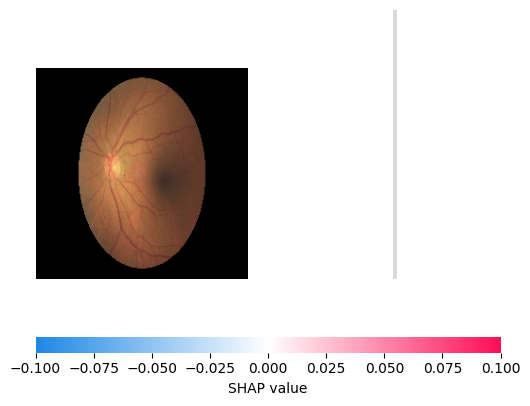

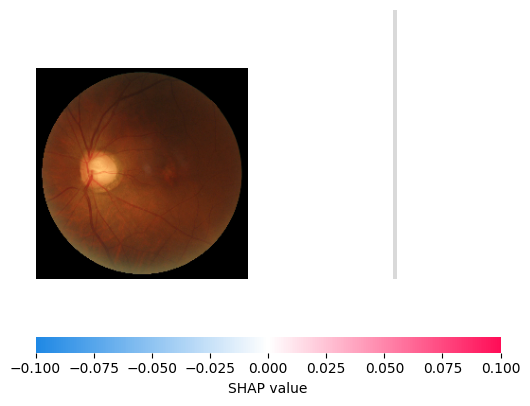

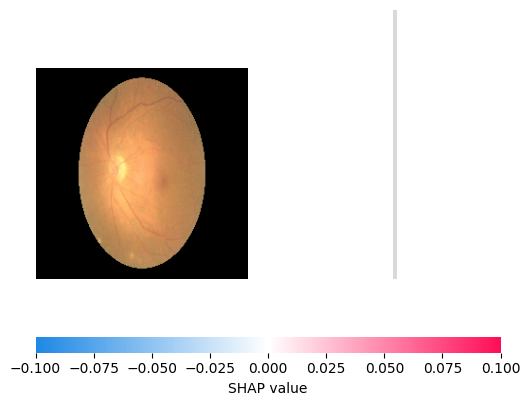

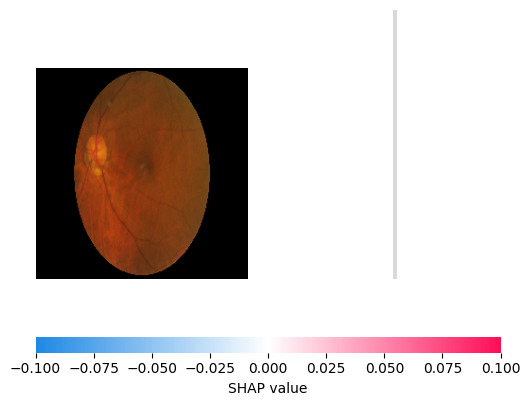

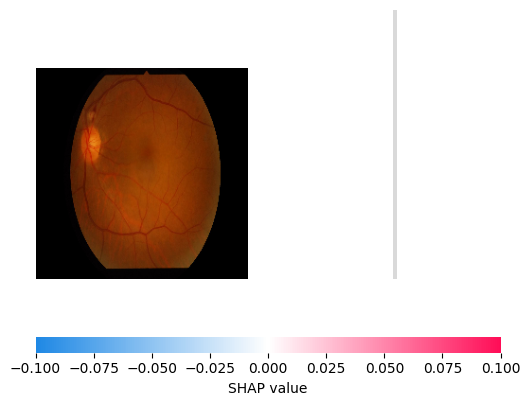

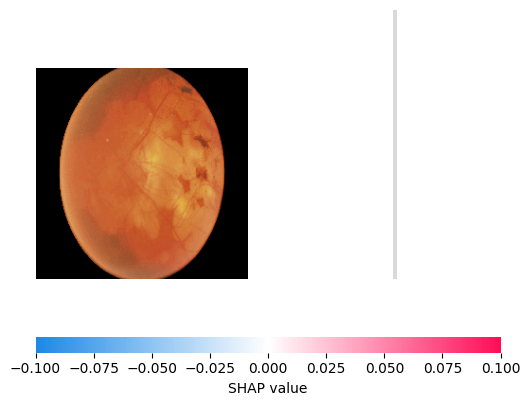

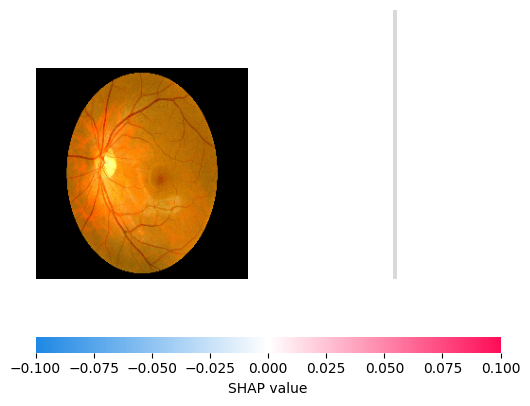

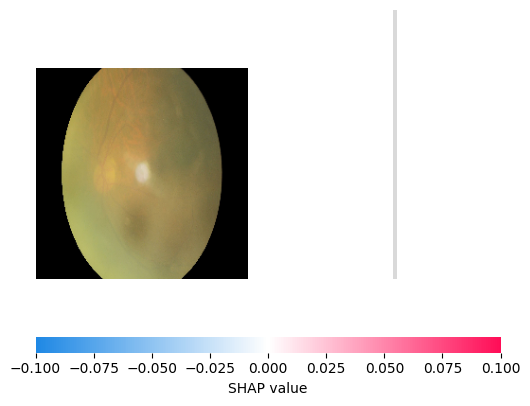

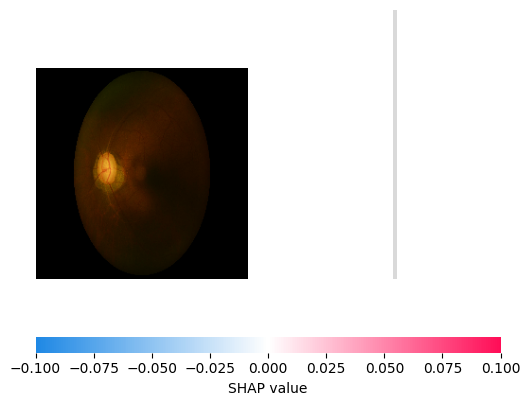

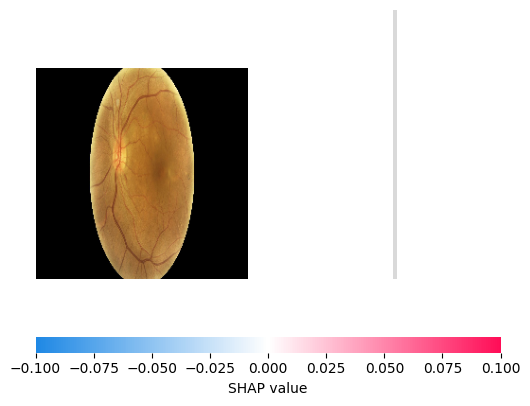

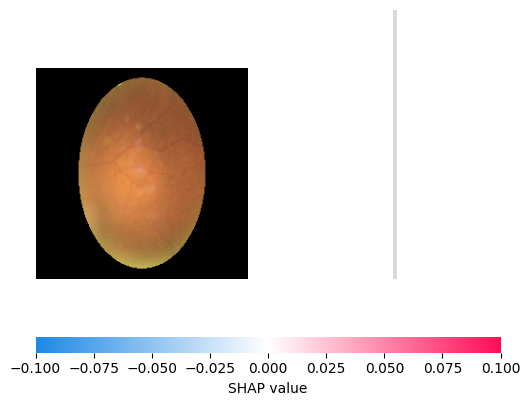

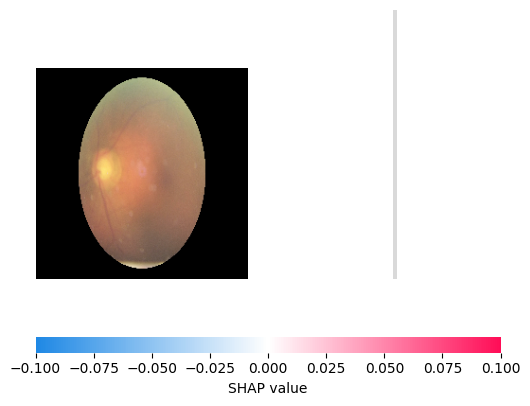

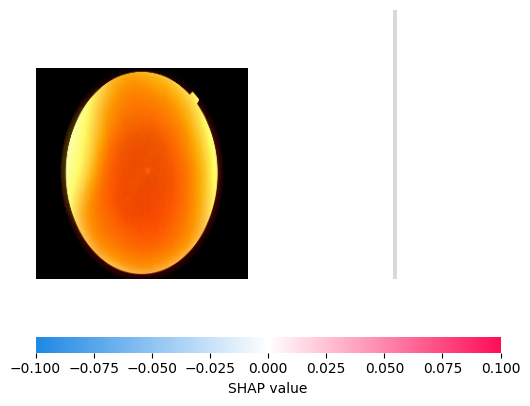

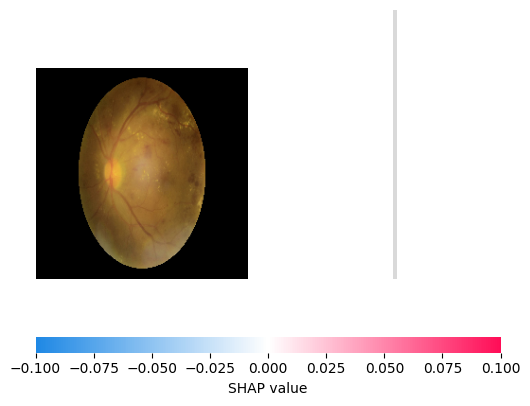

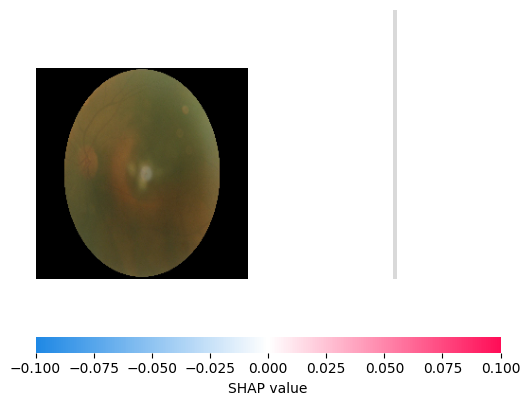

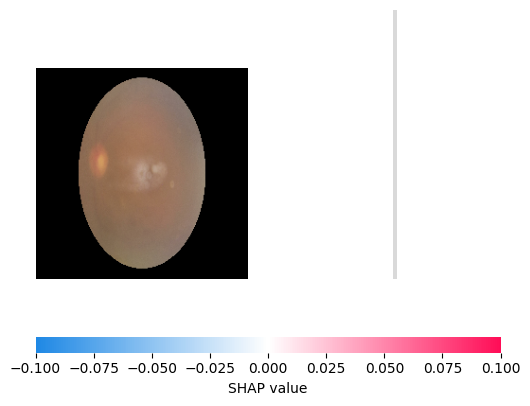

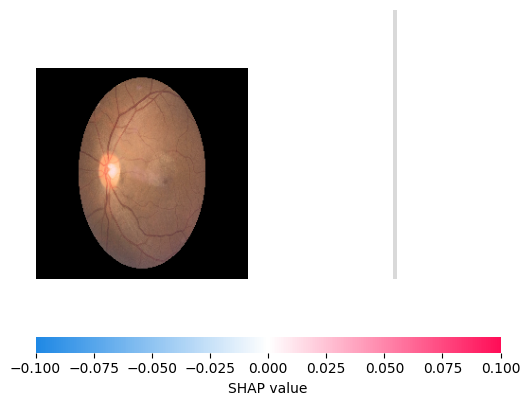

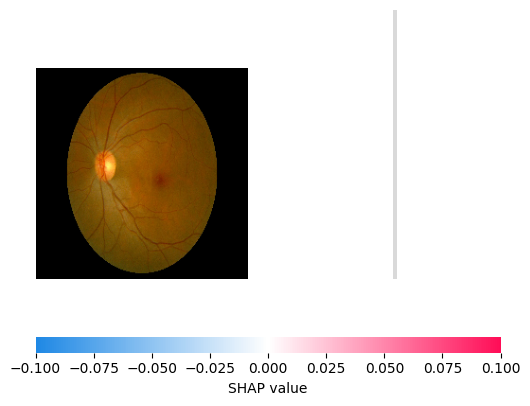

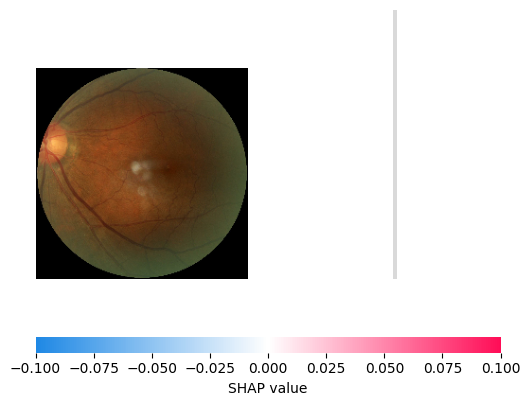

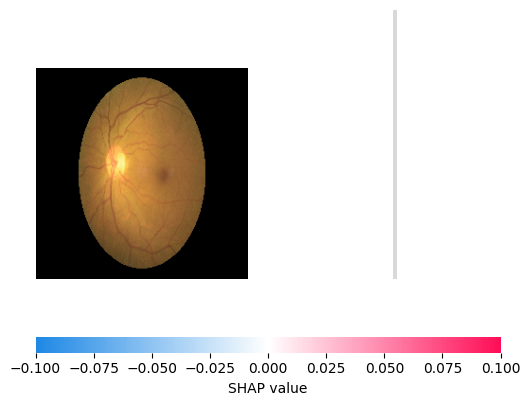

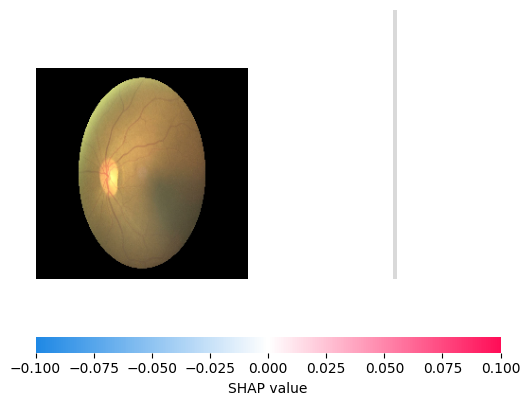

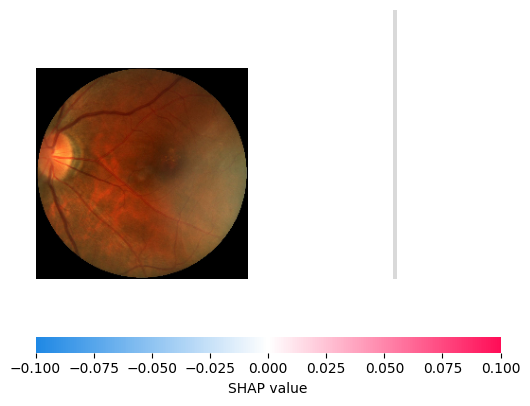

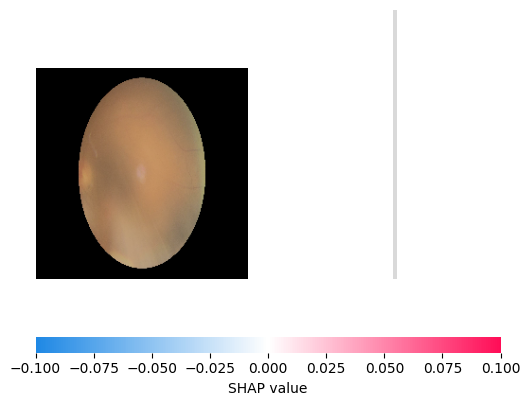

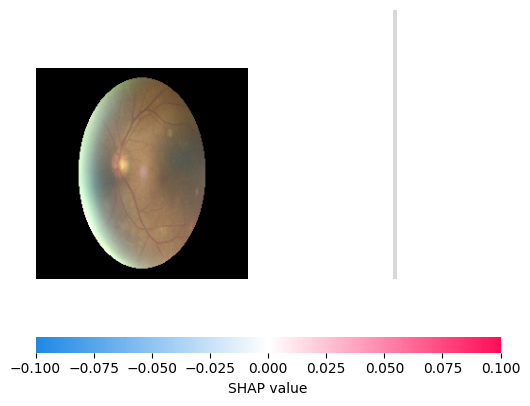

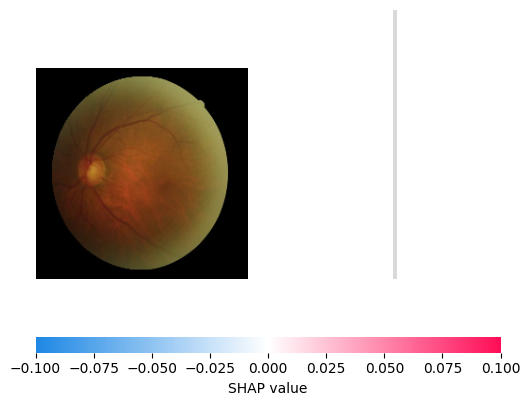

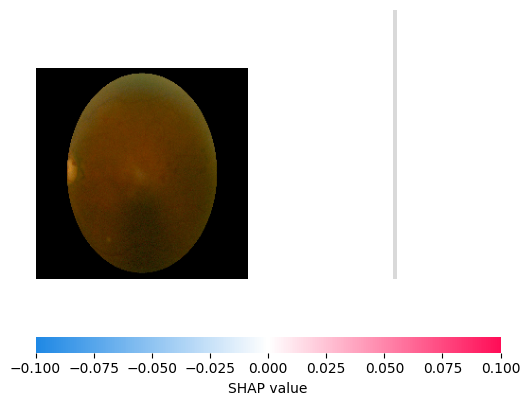

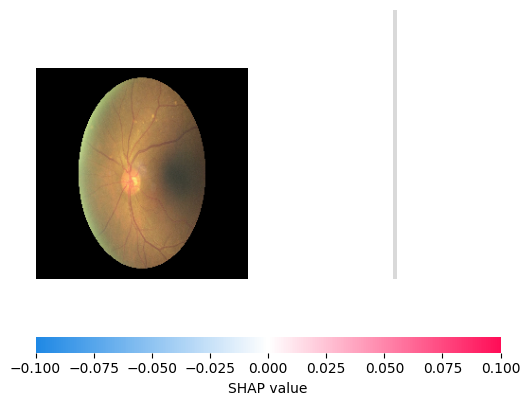

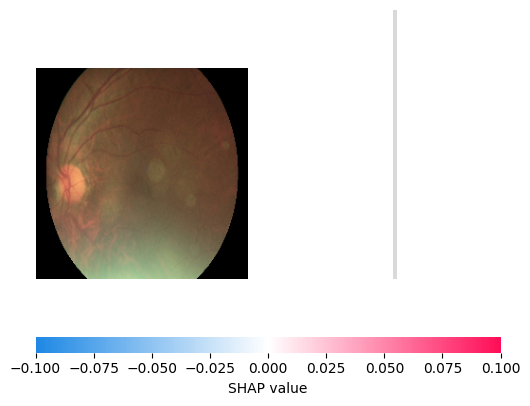

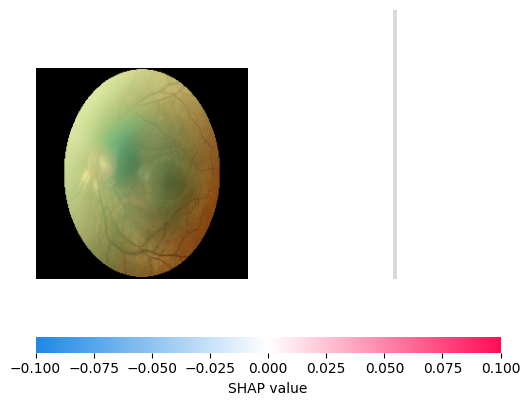

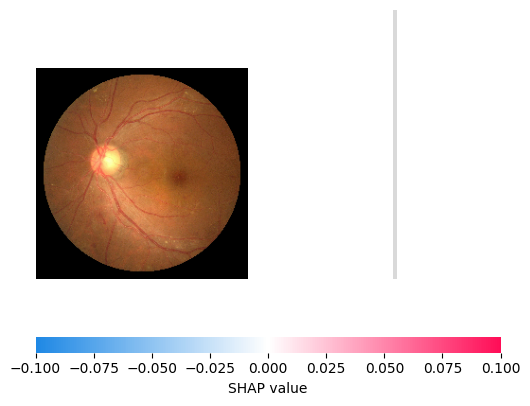

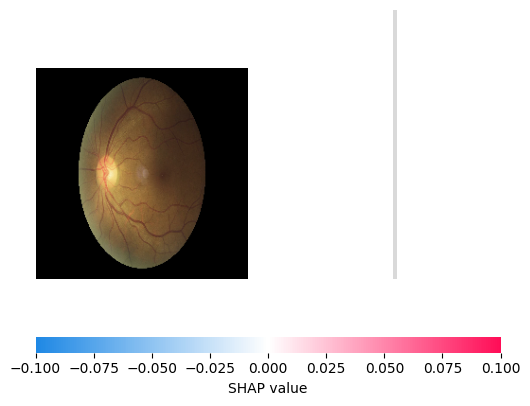

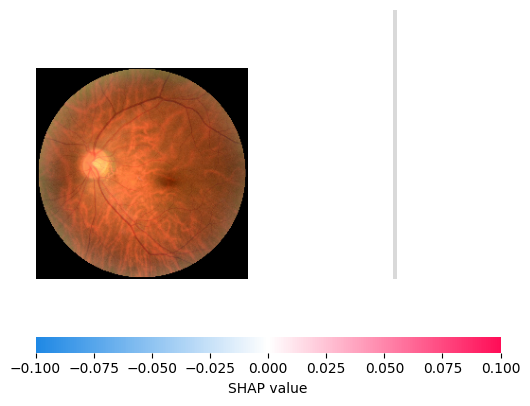

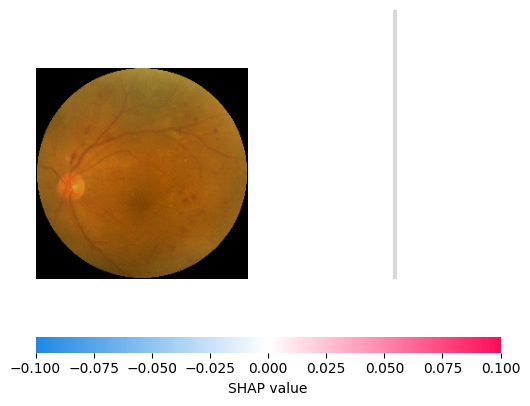

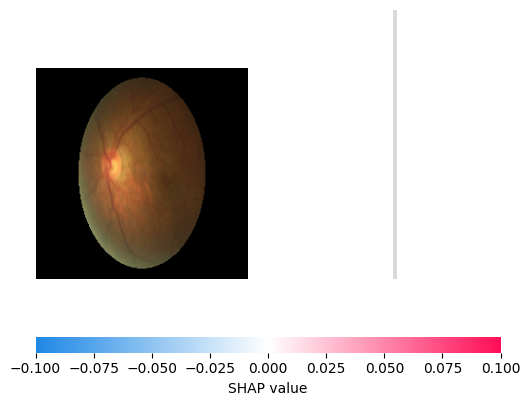

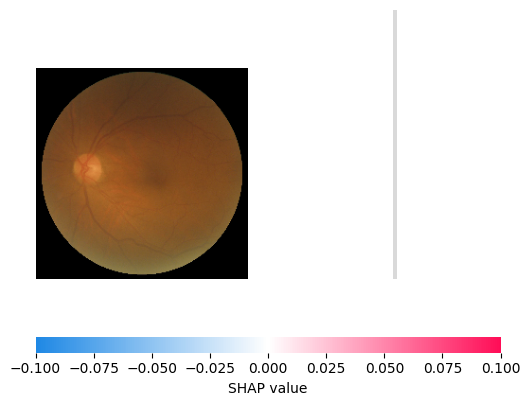

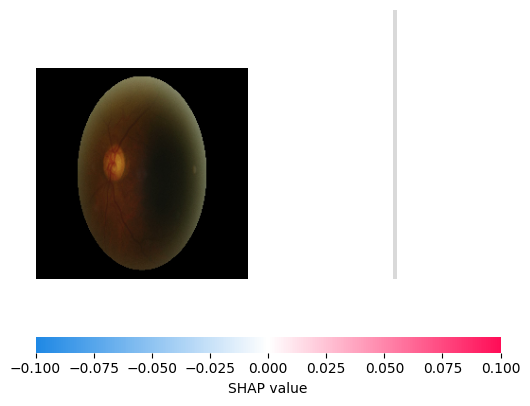

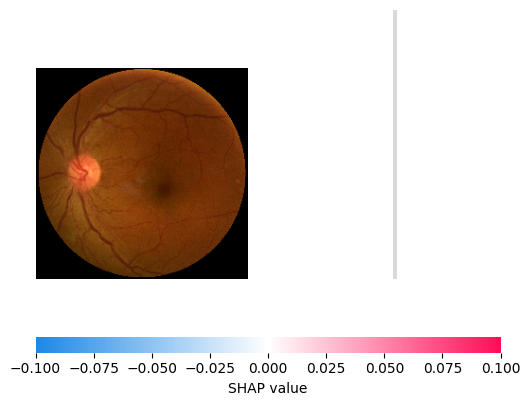

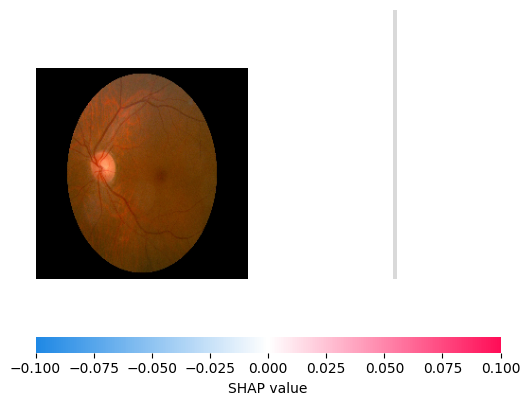

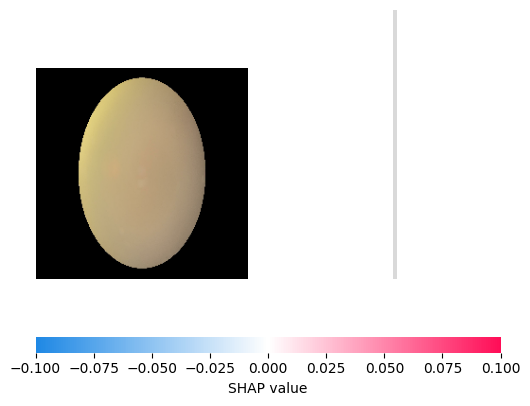

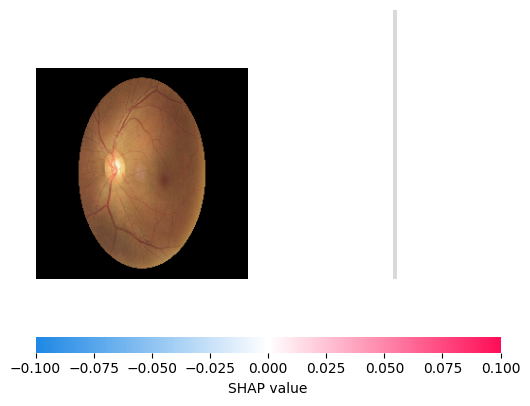

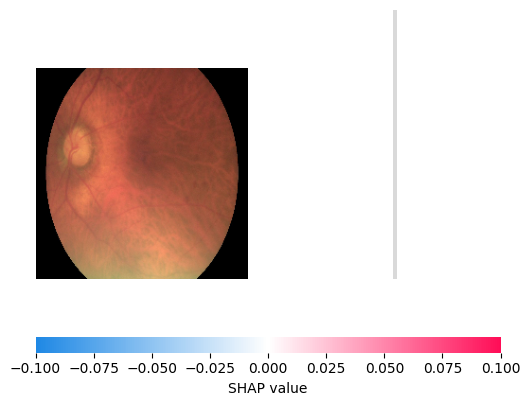

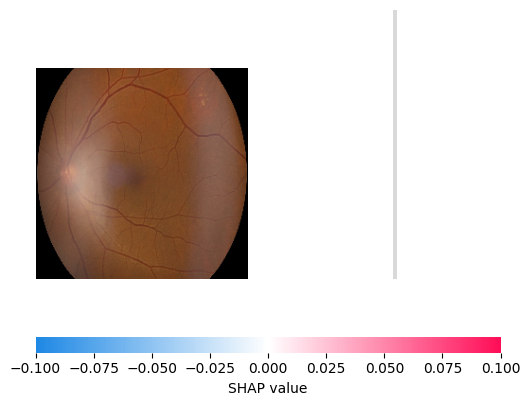

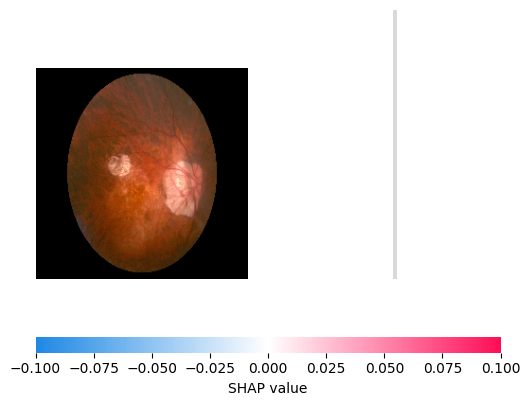

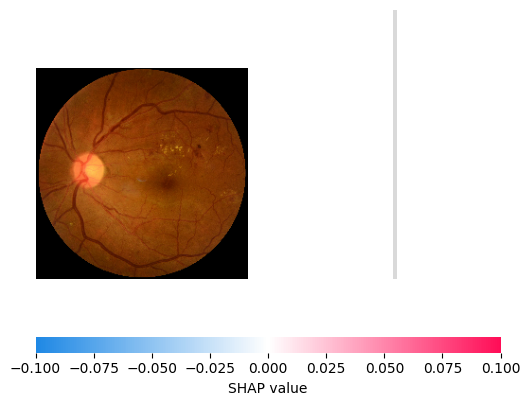

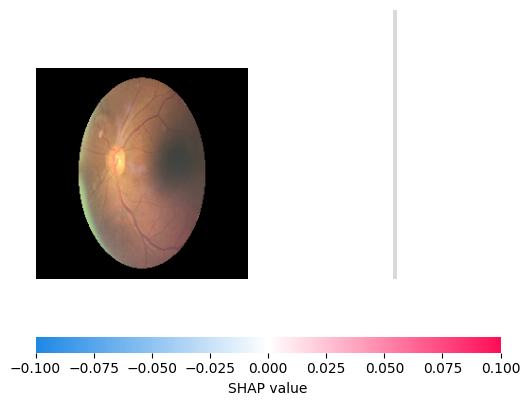

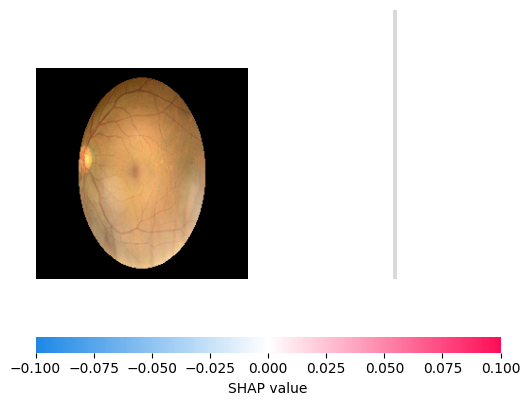

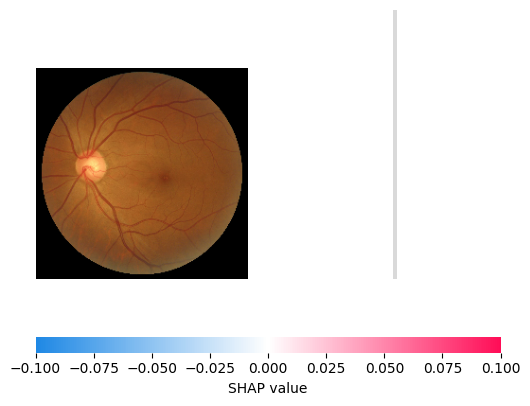

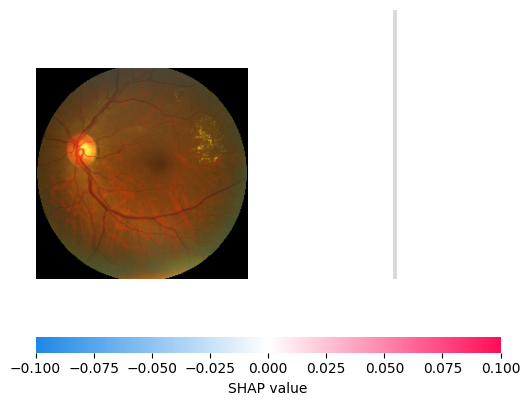

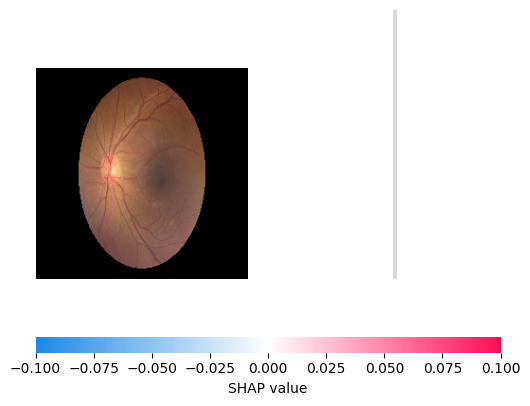

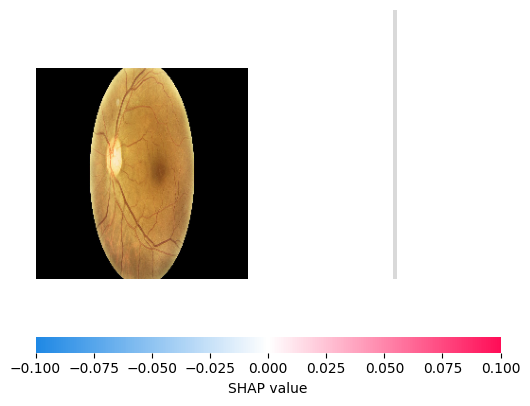

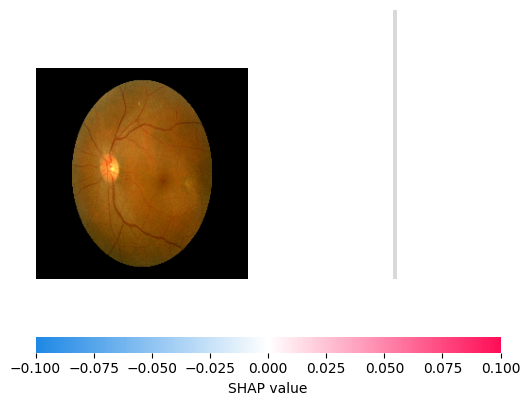

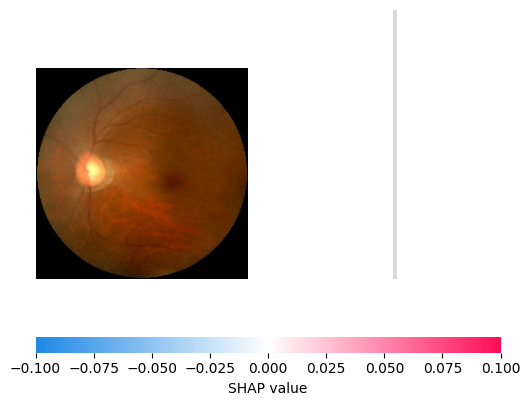

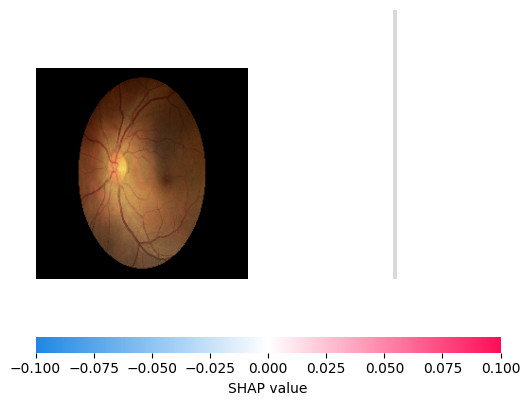

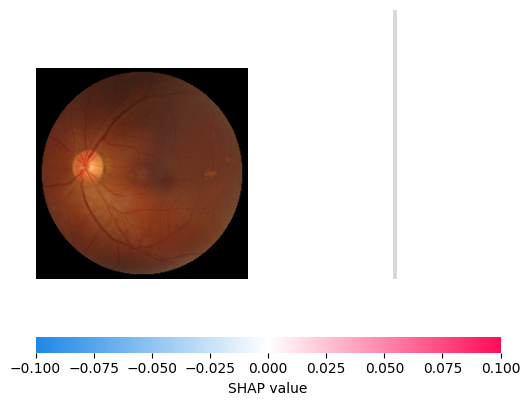

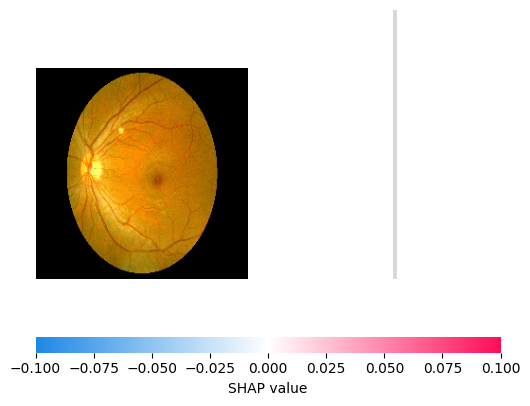

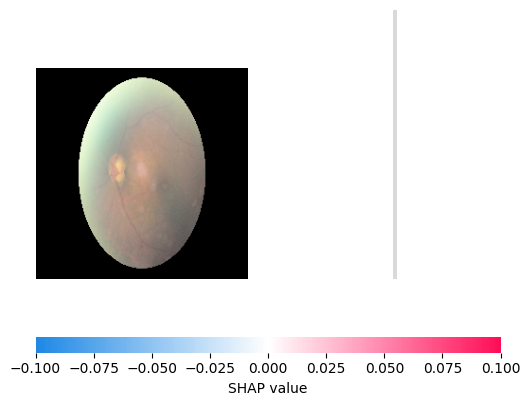

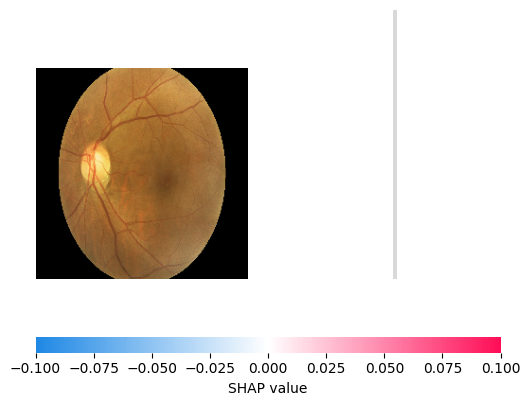

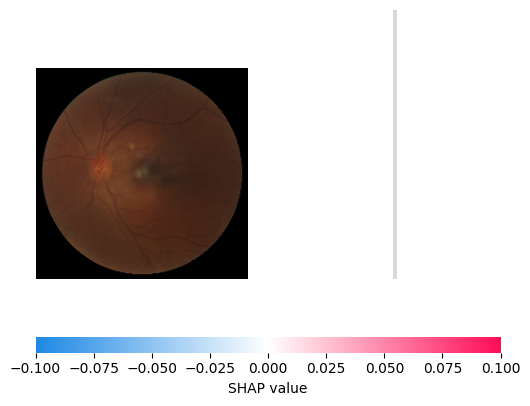

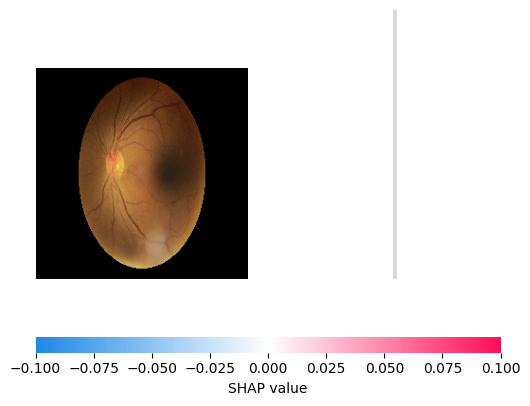

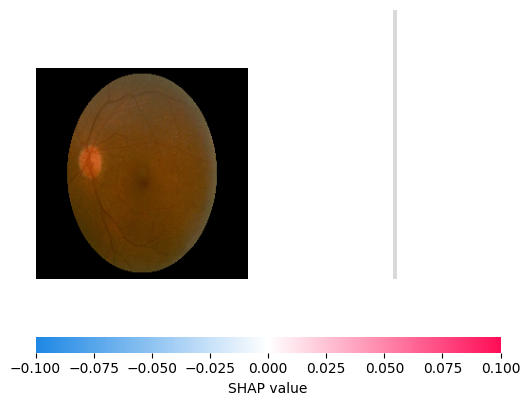

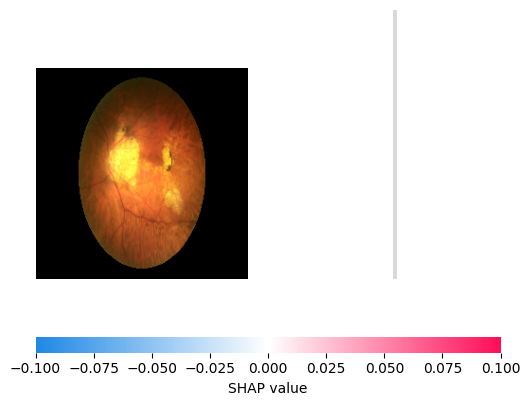

In [ ]:
# Use the take() method to get the first 2 batches from the dataset
batched_dataset = raw_train_ds.take(2)

# Convert the batched_dataset to a list of numpy arrays, which can be processed by SHAP
# ... previous code ...

for images, labels in batched_dataset:
    # Convert EagerTensors to numpy arrays
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

    # Ensure images are in the correct range. This might need adjustment depending on your data.
    numpy_images = numpy_images / 255.0  # Scale to [0, 1] if your images are in the [0, 255] range

    # Now, use the numpy arrays with the explainer
    shap_values = explainer(numpy_images, max_evals=100, batch_size=9)

    # If you have a batch of images, you'll need to pass each set of SHAP values to image_plot individually
    for i in range(len(numpy_images)):
        # Wrap this image's SHAP values in a list to match expected input structure
        current_shap_values = [shap_values[i]]

        # Ensure that pixel_values is a single image, and labels are for the single image
        shap.image_plot(current_shap_values, numpy_images[i:i+1])

    # Break the loop if you only need to plot the first batch
    break


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
import matplotlib.pyplot as plt
import numpy as np

# Assuming `model` is your pre-trained model

def generate_gradcam_heatmap(img_path, model):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    gradcam = Gradcam(model, model_modifier=None, clone=False)
    heatmap = gradcam(loss=lambda output: output.max(), seed_input=img_array, penultimate_layer=-1)
    heatmap = normalize(heatmap)
    return heatmap[0]

# Let's say you want to visualize the first 5 images in your DataFrame
N = 5
for img_path in train_df[''][:N]:
    heatmap = generate_gradcam_heatmap(img_path, model)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()


NameError: name 'img_array' is not defined

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the class prediction we're interested in
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the target class with respect to
    # the output feature map of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This vector is a channel-wise mean of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by this channel-wise mean of the gradient
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization, we normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Use jet colormap to create heatmap
    jet = plt.get_cmap("jet")

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet to colorize heatmap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = j


In [ ]:
# Assume 'preprocess_input' is the appropriate preprocessing function for your model
# img is the raw image
# Taking one batch from the dataset
for img_batch, label_batch in train_ds.take(1):
    # Apply preprocess_input to the image batch
    img_array = preprocess_input(img_batch.numpy())


# Example model and layer names
model = model
last_conv_layer_name = 'conv5_block3_3_conv'  # Example layer name

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display Grad-CAM
display_gradcam(img_array[0], heatmap)


ValueError: No such layer: conv5_block3_3_conv. Existing layers are: ['resnet50', 'dense_6', 'dense_7'].

In [ ]:
from tensorflow.keras.layers import Conv2D

def find_last_conv_layer(model):
    # Reverse iterate over the layers of the model
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, Conv2D):
            # Return the name of the layer if it is
            return layer.name
    # Return None if no convolutional layer is found
    return None

# Find the last convolutional layer in the base model
last_conv_layer_name = find_last_conv_layer(pretrained_model)
print("Last convolutional layer name in the base model:", last_conv_layer_name)

# If inspecting the entire model, the function now also checks nested models
last_conv_layer_name_entire_model = find_last_conv_layer(model)
print("Last convolutional layer name in the entire model:", last_conv_layer_name_entire_model)


Last convolutional layer name in the base model: conv5_block3_3_conv
Last convolutional layer name in the entire model: None
